In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import torch.nn.functional as F


class GazeNet(nn.Module):
    # GazeNet with 3 output layers for yaw, pitch and roll
    # Predicts Euler angles by binning and regression with the expected value
    def __init__(self, block, layers, num_bins):
        self.inplanes = 64
        super(GazeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_yaw = nn.Linear(512 * block.expansion, num_bins)
        self.fc_pitch = nn.Linear(512 * block.expansion, num_bins)
        self.fc_roll = nn.Linear(512 * block.expansion, num_bins)

        # Vestigial layer from previous experiments
        self.fc_finetune = nn.Linear(512 * block.expansion + 3, 3)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        pre_yaw = self.fc_yaw(x)
        pre_pitch = self.fc_pitch(x)
        pre_roll = self.fc_roll(x)

        return pre_yaw, pre_pitch, pre_roll


class ResNet(nn.Module):
    # ResNet for regression of 3 Euler angles.
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_angles = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_angles(x)
        return x


class AlexNet(nn.Module):
    # AlexNet laid out as a GazeNet - classify Euler angles in bins and
    # regress the expected value.
    def __init__(self, num_bins):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )
        self.fc_yaw = nn.Linear(4096, num_bins)
        self.fc_pitch = nn.Linear(4096, num_bins)
        self.fc_roll = nn.Linear(4096, num_bins)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        yaw = self.fc_yaw(x)
        pitch = self.fc_pitch(x)
        roll = self.fc_roll(x)
        return yaw, pitch, roll

In [26]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

# import vendgaze


class Gazenet:

    def __init__(self, model_path):
        self.model = Gazenet._load_model(model_path)
        self.idx_tensor = torch.FloatTensor([idx for idx in range(66)])

    def image_to_euler_angles(self, image, bboxes):
        # image: width x height x 3
        x_min = max(bboxes[0] - 50, 0)
        x_max = min(image.shape[1], bboxes[1] + 50)
        y_min = max(bboxes[2] - 50, 0)
        y_max = min(image.shape[0], bboxes[3] + 50)

        image = Image.fromarray(image)
        image = self._transform(image)
        image_shape = image.size()
        image = image.view(1, image_shape[0], image_shape[1], image_shape[2])

        yaw, pitch, roll = self.model(Variable(image))

        yaw_pred = F.softmax(yaw)
        pitch_pred = F.softmax(pitch)
        roll_pred = F.softmax(roll)

        return self._map_angles_to_continuous(yaw_pred, pitch_pred, roll_pred)

    def _map_angles_to_continuous(self, yaw, pitch, roll):
        return map(
            lambda x: torch.sum(x[0] * self.idx_tensor) * 3 - 99, 
            [yaw, pitch, roll]
            )

    def _transform(self, image):
        transformations = transforms.Compose(
            [
                transforms.Scale(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )
            ]
        )

        return transformations(image)

    @staticmethod
    def _load_model(model_path):
        model = GazeNet(
            block=torchvision.models.resnet.Bottleneck, 
            layers=[3, 4, 6, 3],
            num_bins=66
        )
        saved_state_dict = torch.load(model_path, map_location='cpu')
        model.eval()

        return model

In [27]:
g = Gazenet('../models/gaze/hopenet_robust_alpha1.pkl')

In [16]:
import cv2
from matplotlib import pyplot as plt

In [10]:
im = cv2.imread('../data/images/kavanaugh.png')

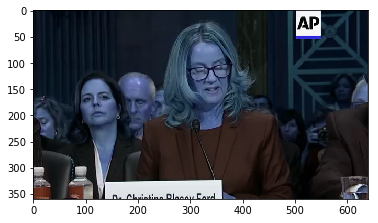

In [19]:
plt.imshow(im)

In [17]:
im.shape

(360, 640, 3)

In [29]:
res = g.image_to_euler_angles(im, [250, 400, 25, 200])

/home/elijahtai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/elijahtai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/elijahtai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [30]:
list(res)

[tensor(-98.5288, grad_fn=<SubBackward>),
 tensor(-85.2799, grad_fn=<SubBackward>),
 tensor(6.0066, grad_fn=<SubBackward>)]